# Chapter 4 : The mechanics of learning

### 1. Redefine the model to be w2\*t_u\*\*2+w1\*t_u+b.
* What parts of the training loop, and so on, need to change to accommodate this redefinition?
* What parts are agnostic to swapping out the model?
* Is the resulting loss higher or lower after training?
* Is the actual result better or worse?

There are two measurements, one in celsius (with a thermometer in celsius) and one in an unknown unit (with a thermometer with unknown unit). We want to train a model on data with understandable unit to interpret the new readings.\
First, we suggest the two units are linearly related. Then we'll try another modeling, which is the purpose of the exercise.

Since we are trying to train a model to predict a continuous variable (a temperature), this problem is a ***regression problem***.

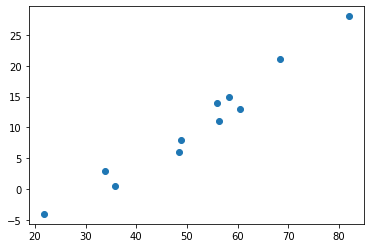

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

t_celsius = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] 
t_mesurement = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] 
t_celsius = torch.tensor(t_celsius)
t_mesurement = torch.tensor(t_mesurement)

plt.figure()
plt.scatter(t_mesurement, t_celsius);


In [2]:
### Model definition
def model_lin(t_mesurement, w, b):
    """
    Our linear model
    """
    return w * t_mesurement + b

def model_nonlin(t_mesurement, w1, w2, b):
    """
    Our non-linear model
    """
    return w2*t_mesurement**2+w1*t_mesurement+b


### Loss function definition
def loss_fn(t_predict, t_celsius):
    """
    Mean square loss
    """
    squared_diffs = (t_predict - t_celsius)**2
    return squared_diffs.mean()

Note : it is appropriate to define our loss function like above since we are dealing with a regression problem.

In [3]:
### Training loop definition
def training_loop(n_epochs, model, optimizer, params, train_t_mesurement, val_t_mesurement, 
                  train_t_celsius, val_t_celsius):
    for epoch in range(1, n_epochs + 1):         
        train_t_predict = model(train_t_mesurement, *params) # Predict train values
        train_loss = loss_fn(train_t_predict, train_t_celsius)

        val_t_predict = model(val_t_mesurement, *params) # Predict validation values
        val_loss = loss_fn(val_t_predict, val_t_celsius)
        
        optimizer.zero_grad() # Clear gradients
        train_loss.backward() # accumulate derivatives at leaf nodes
        optimizer.step() # Update the value of parameters according to the optimization strategy

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            f" Validation loss {val_loss.item():.4f}")
    
    return params

In [4]:
### Setting train/validation indices (we use a 80%/20% ratio)
n_samples = t_mesurement.shape[0] 
n_val = int(0.2 * n_samples) 
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val] 
val_indices = shuffled_indices[-n_val:]


### Creating train/validation data
train_t_mesurement = t_mesurement[train_indices]
train_t_celsius = t_celsius[train_indices]

val_t_mesurement = t_mesurement[val_indices]
val_t_celsius = t_celsius[val_indices]

In [5]:
### Optimizer definition
import torch.optim as optim

w1 = 1.0 
b = 0.0
params_lin = torch.tensor([w1, b], requires_grad=True)

learning_rate = 1e-2
optimizer_lin = optim.SGD([params_lin], lr=learning_rate) # Using  optimizer 

### Training our linear model
trained_params = training_loop(
    n_epochs = 3000,
    model = model_lin,
    optimizer = optimizer_lin,
    params = params_lin,
    train_t_mesurement = train_t_mesurement * 0.1,
    val_t_mesurement = val_t_mesurement * 0.1,
    train_t_celsius = train_t_celsius,
    val_t_celsius = val_t_celsius)

print("\nWith a linear model : \nw_trained = ", trained_params[0], "\nb_trained = ", trained_params[1])

Epoch 1, Training loss 85.6554, Validation loss 56.5547
Epoch 2, Training loss 43.9632, Validation loss 11.2589
Epoch 3, Training loss 36.8792, Validation loss 4.2194
Epoch 500, Training loss 7.1544, Validation loss 2.7312
Epoch 1000, Training loss 3.5517, Validation loss 2.5743
Epoch 1500, Training loss 3.1001, Validation loss 2.5225
Epoch 2000, Training loss 3.0435, Validation loss 2.5046
Epoch 2500, Training loss 3.0364, Validation loss 2.4983
Epoch 3000, Training loss 3.0355, Validation loss 2.4961

With a linear model : 
w_trained =  tensor(5.3719, grad_fn=<SelectBackward>) 
b_trained =  tensor(-17.2278, grad_fn=<SelectBackward>)


**Note** : we use stochastic gradient descent optimizer (SGD) but it is actually a simple gradient descent since its momentum argument is set to zero (default), and the loss is evaluated on all the samples.

**Note 2** : we normalized `t_mesurement` to keep parameters in the same scale (and so the gardients). Also, SGD is quite sensitive to the scaling of parameters (see Chap5.4 - Chap5.5)

To train our non-linear model (w2\*t_u\*\*2+w1\*t_u+b), we'll add a `model` variable to the function `training_loop` and we'll creat a `w2` param (set to 1 as `w1`) and redefine our optimizer. \
Let's see how behaves our new non-linear model.

In [6]:
w1 = 1.0
w2 = 1.0
b = 0.0
params_nonlin = torch.tensor([w1, w2, b], requires_grad=True)

learning_rate = 1e-2
optimizer_nonlin = optim.SGD([params_nonlin], lr=learning_rate)

trained_params = training_loop(
    n_epochs = 3000,
    model = model_nonlin,
    optimizer = optimizer_nonlin,
    params = params_nonlin,
    train_t_mesurement = train_t_mesurement * 0.1,
    val_t_mesurement = val_t_mesurement * 0.1,
    train_t_celsius = train_t_celsius,
    val_t_celsius = val_t_celsius)

print("\nWith a non-linear model : \nw_trained = ", 
      trained_params[0], "\nb_trained = ", trained_params[1])

Epoch 1, Training loss 681.2131, Validation loss 651.4102
Epoch 2, Training loss 343937.4062, Validation loss 320902.0625
Epoch 3, Training loss 177811296.0000, Validation loss 166189920.0000
Epoch 500, Training loss nan, Validation loss nan
Epoch 1000, Training loss nan, Validation loss nan
Epoch 1500, Training loss nan, Validation loss nan
Epoch 2000, Training loss nan, Validation loss nan
Epoch 2500, Training loss nan, Validation loss nan
Epoch 3000, Training loss nan, Validation loss nan

With a non-linear model : 
w_trained =  tensor(nan, grad_fn=<SelectBackward>) 
b_trained =  tensor(nan, grad_fn=<SelectBackward>)


Here, the training loss and validation loss blow to infinity. Let's investigate what is swapping out our model.

In [12]:
w1 = 1.0
w2 = 1.0
b = 0.0
params_nonlin = torch.tensor([w1, w2, b], requires_grad=True)

learning_rate = 1e-4
optimizer_nonlin = optim.SGD([params_nonlin], lr=learning_rate)

trained_params = training_loop(
    n_epochs = 5000,
    model = model_nonlin,
    optimizer = optimizer_nonlin,
    params = params_nonlin,
    train_t_mesurement = train_t_mesurement * 0.1,
    val_t_mesurement = val_t_mesurement * 0.1,
    train_t_celsius = train_t_celsius,
    val_t_celsius = val_t_celsius)

print("\nWith a non-linear model : \nw_trained = ", 
      trained_params[0], "\nb_trained = ", trained_params[1])

Epoch 1, Training loss 681.2131, Validation loss 651.4102
Epoch 2, Training loss 402.8719, Validation loss 384.9200
Epoch 3, Training loss 240.9869, Validation loss 228.7853
Epoch 500, Training loss 11.9509, Validation loss 2.6261
Epoch 1000, Training loss 9.2196, Validation loss 2.4695
Epoch 1500, Training loss 7.3807, Validation loss 2.4493
Epoch 2000, Training loss 6.1420, Validation loss 2.5055
Epoch 2500, Training loss 5.3073, Validation loss 2.6000
Epoch 3000, Training loss 4.7442, Validation loss 2.7100
Epoch 3500, Training loss 4.3639, Validation loss 2.8218
Epoch 4000, Training loss 4.1066, Validation loss 2.9277
Epoch 4500, Training loss 3.9320, Validation loss 3.0240
Epoch 5000, Training loss 3.8131, Validation loss 3.1090

With a non-linear model : 
w_trained =  tensor(-1.0316, grad_fn=<SelectBackward>) 
b_trained =  tensor(0.5763, grad_fn=<SelectBackward>)


By changing the learning rate to `1e-4`, the gradient descent is smoother and doesn't blow the parameters (and so, the gradients). \
It seems that we are converging and everythings went weel. 

Let's try to modify our optimizer using an Adam strategy in which the learning-rate is set adaptively. Also, it is less sensitive to the scale of parameters, so we can go back to our non-scaled mesurements.

In [13]:
w1 = 1.0
w2 = 1.0
b = 0.0
params_nonlin = torch.tensor([w1, w2, b], requires_grad=True)

learning_rate = 1e-1
optimizer_nonlin = optim.Adam([params_nonlin], lr=learning_rate) # Using Adam strategy

trained_params = training_loop(
    n_epochs = 3000,
    model = model_nonlin,
    optimizer = optimizer_nonlin,
    params = params_nonlin,
    train_t_mesurement = train_t_mesurement,
    val_t_mesurement = val_t_mesurement,
    train_t_celsius = train_t_celsius,
    val_t_celsius = val_t_celsius)

print("\nWith a non-linear model :")
print("w1_trained = ", trained_params[0])
print("w2_trained = ", trained_params[1])
print("b_trained = ", trained_params[2])

Epoch 1, Training loss 11855569.0000, Validation loss 11052040.0000
Epoch 2, Training loss 9594152.0000, Validation loss 8943740.0000
Epoch 3, Training loss 7579711.0000, Validation loss 7065715.0000
Epoch 500, Training loss 5.0972, Validation loss 2.5617
Epoch 1000, Training loss 3.7968, Validation loss 2.9736
Epoch 1500, Training loss 3.4956, Validation loss 3.3177
Epoch 2000, Training loss 3.4467, Validation loss 3.4389
Epoch 2500, Training loss 3.4148, Validation loss 3.4434
Epoch 3000, Training loss 3.3751, Validation loss 3.4161

With a non-linear model :
w1_trained =  tensor(-0.1078, grad_fn=<SelectBackward>)
w2_trained =  tensor(0.0060, grad_fn=<SelectBackward>)
b_trained =  tensor(-1.7348, grad_fn=<SelectBackward>)


Here, we initialized the learning rate at `0.1`. The training loss is slightly lower than the validation loss and both are close to zero. They are very close together, which means overfitting is under controlled. \
It seems that the SGD method (which is a classic gradient descent here) gives sufficient performance to avoid using more sophisticated optimizer like Adam.

As a conclusion, the validation loss with the non-linear model doesn't seem to be better than those with the linear one. The linear model will lead to better generalization. We should use the linear model even if the non-linear one gives us acceptable results.

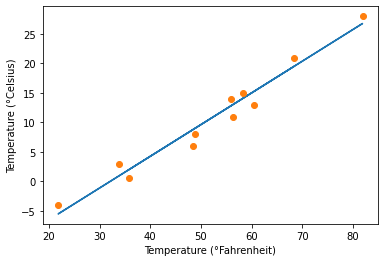

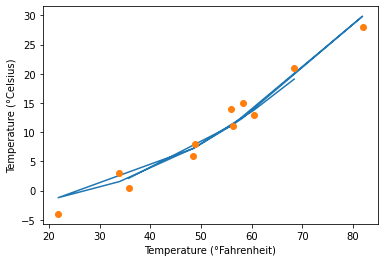

In [14]:
t_predict_lin = model_lin(t_mesurement*0.1, *params_lin)
fig1 = plt.figure()
plt.xlabel("Temperature (°Fahrenheit)") 
plt.ylabel("Temperature (°Celsius)") 
plt.plot(t_mesurement.numpy(), t_predict_lin.detach().numpy()) 
plt.plot(t_mesurement.numpy(), t_celsius.numpy(), 'o')

t_predict_nonlin = model_nonlin(t_mesurement, *params_nonlin)
fig2 = plt.figure()
plt.xlabel("Temperature (°Fahrenheit)") 
plt.ylabel("Temperature (°Celsius)") 
plt.plot(t_mesurement.numpy(), t_predict_nonlin.detach().numpy()) 
plt.plot(t_mesurement.numpy(), t_celsius.numpy(), 'o');

**Note** : i have to admit that the shape of the non-linear curve bothers me... I couldn't find why it results in this weird shape. Feel free to correct me (if i'm wrong) or to discuss with me if you have any lead. 